In [1]:
%load_ext autoreload
%autoreload 2

curr_dir = '/home/nblauch/git/goodale-milner-test'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sys
vone_dir = '/home/nblauch/git/INACTIVE/vonenet'
cornet_dir = '/home/nblauch/git/INACTIVE/CORnet'

sys.path.insert(1, vone_dir)
sys.path.insert(1, cornet_dir)
import vonenet
import cornet

import torch

import torch.nn as nn
import torchvision
from torchvision.models import resnet18, alexnet, vgg19, vgg11

import load_stim
from sklearn.model_selection import StratifiedShuffleSplit

from sklearn import svm

import warnings
warnings.filterwarnings('ignore')


In [2]:
splits = 3


transform = torchvision.transforms.Compose([
                torchvision.transforms.Resize(224),
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                                 std=[0.5, 0.5, 0.5]),
#                 torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
#                                      std=[0.229, 0.224, 0.225])
            ])

In [3]:
def load_model(model_arch):   
    if model_arch =='cornet_z':
        model = cornet.get_model('z', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='cornet_s':
        model = cornet.get_model('s', pretrained=True, map_location=torch.device('cpu')).module

    elif model_arch =='alexnet':
        model = alexnet(pretrained=True)

    elif model_arch =='vgg19':
        model = vgg19(pretrained=True)

    elif model_arch =='resnet18':
        model = resnet18(pretrained=True)
        
    return model

In [4]:
def extract_acts(model, image_dir, transform, layer_names):
    imNum = 0
    n=0

    test_dataset =torchvision.datasets.ImageFolder(image_dir, transform=transform)

    #test_dataset = load_stim.load_stim(image_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 4, pin_memory=True)

    with torch.no_grad():
        
        for data, _ in testloader:
            # move tensors to GPU if CUDA is available
            
            #data= data.cuda()
            
            activations = get_all_feature
            
            _model_feats = []
            model(data.to('cuda'))
            #output = model(data)
            
            out = np.vstack(_model_feats)
            

            if n == 0:
                acts = out
                #label_list = label
            else:
                acts= np.append(acts, out,axis = 0)
                #label_list = np.append(label_list, label)
                
            
            n = n + 1

    return acts

def get_loader(stim_dir):
    test_dataset =torchvision.datasets.ImageFolder(stim_dir, transform=transform)
    testloader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=False, num_workers = 0, pin_memory=False)
    return testloader, test_dataset


In [7]:
import sys
sys.path.append('DeepDive')
from deepdive.feature_extraction import get_empty_feature_maps, StimulusSet, get_all_feature_maps

models = ['alexnet','vgg19','resnet18','cornet_z','cornet_s']
testloader, test_dataset = get_loader(f'{curr_dir}/stim/allv1_rect')

## print out named layers for each model
for model_arch in models:
    print(model_arch+ '\n')
    model_layers = get_empty_feature_maps(load_model(model_arch), testloader, names_only = True)
    print(model_layers)
    print('\n')

alexnet

['Conv2d-1', 'ReLU-1', 'MaxPool2d-1', 'Conv2d-2', 'ReLU-2', 'MaxPool2d-2', 'Conv2d-3', 'ReLU-3', 'Conv2d-4', 'ReLU-4', 'Conv2d-5', 'ReLU-5', 'MaxPool2d-3', 'Linear-1', 'ReLU-6', 'Linear-2', 'ReLU-7', 'Linear-3']


vgg19

['Conv2d-1', 'ReLU-1', 'Conv2d-2', 'ReLU-2', 'MaxPool2d-1', 'Conv2d-3', 'ReLU-3', 'Conv2d-4', 'ReLU-4', 'MaxPool2d-2', 'Conv2d-5', 'ReLU-5', 'Conv2d-6', 'ReLU-6', 'Conv2d-7', 'ReLU-7', 'Conv2d-8', 'ReLU-8', 'MaxPool2d-3', 'Conv2d-9', 'ReLU-9', 'Conv2d-10', 'ReLU-10', 'Conv2d-11', 'ReLU-11', 'Conv2d-12', 'ReLU-12', 'MaxPool2d-4', 'Conv2d-13', 'ReLU-13', 'Conv2d-14', 'ReLU-14', 'Conv2d-15', 'ReLU-15', 'Conv2d-16', 'ReLU-16', 'MaxPool2d-5', 'Linear-1', 'ReLU-17', 'Linear-2', 'ReLU-18', 'Linear-3']


resnet18

['Conv2d-1', 'BatchNorm2d-1', 'ReLU-1', 'MaxPool2d-1', 'Conv2d-2', 'BatchNorm2d-2', 'ReLU-2', 'Conv2d-3', 'BatchNorm2d-3', 'ReLU-3', 'Conv2d-4', 'BatchNorm2d-4', 'ReLU-4', 'Conv2d-5', 'BatchNorm2d-5', 'ReLU-5', 'Conv2d-6', 'BatchNorm2d-6', 'ReLU-6', 'Conv2d-

# Classification accuracy

In [8]:
from sklearn.linear_model import RidgeCV

def classify(acts, labels, splits):

    sss = StratifiedShuffleSplit(n_splits=splits, test_size=0.2)
    #run classifier
    acc = np.zeros(splits)
    for i, (train_index, test_index) in enumerate(sss.split(acts, labels)):
        X_train, X_test = acts[train_index], acts[test_index]
        y_train, y_test = labels[train_index], labels[test_index]
#         clf = svm.SVC()
        clf = RidgeCV()
        clf.fit(X_train.reshape(X_train.shape[0], -1), y_train)
        acc[i] = clf.score(X_test.reshape(X_test.shape[0],-1), y_test)
        
        

    return acc

['rect1', 'rect2', 'rect3', 'rect4']

  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 17.61it/s]


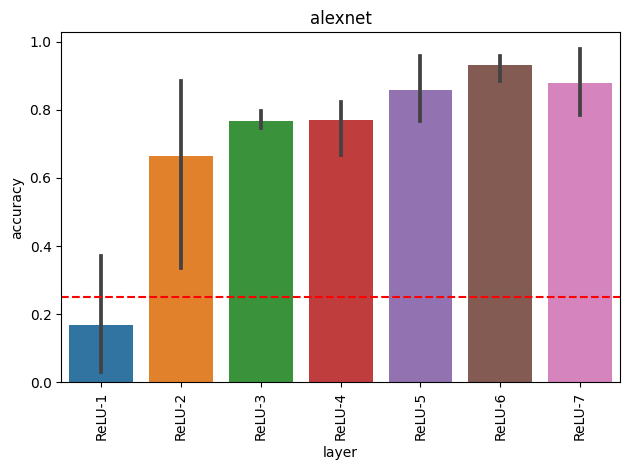

 20%|██████████████████▍                                                                         | 1/5 [00:02<00:10,  2.58s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.04it/s]


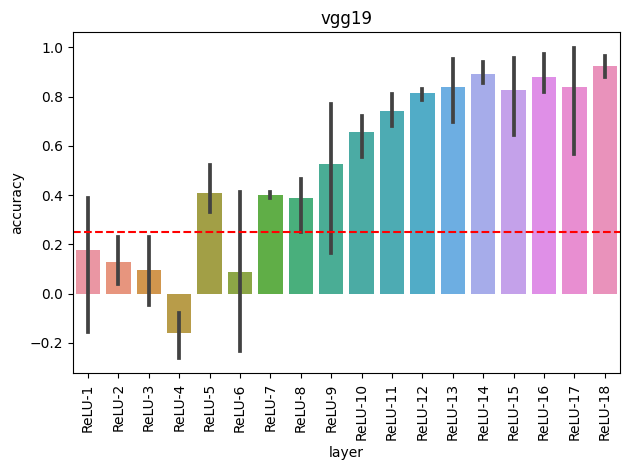

 40%|████████████████████████████████████▊                                                       | 2/5 [00:27<00:47, 15.96s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  8.37it/s]


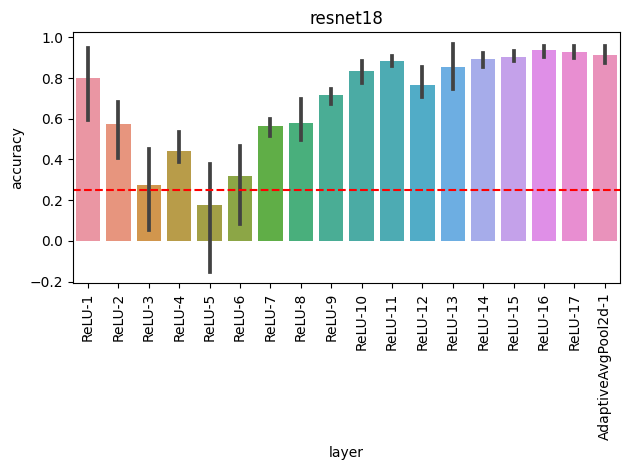

 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:33<00:22, 11.29s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.73it/s]


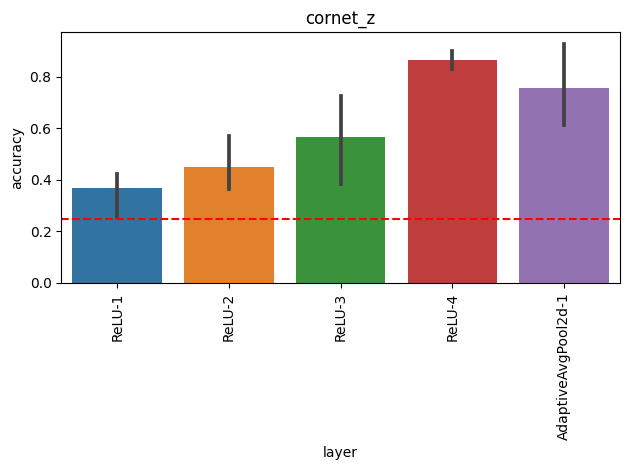

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:36<00:08,  8.15s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:09<00:00,  2.95it/s]


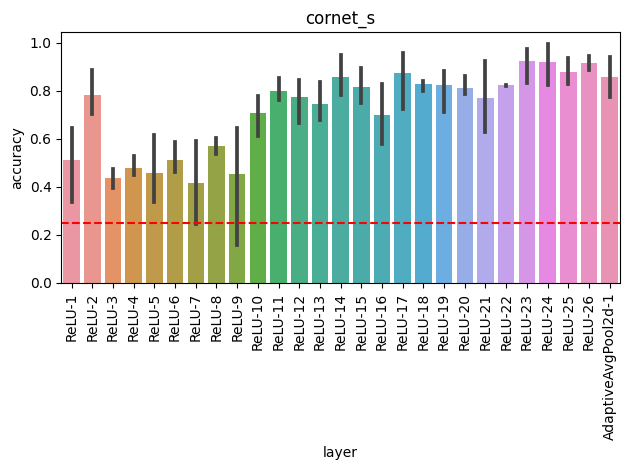

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:54<00:00, 10.83s/it]


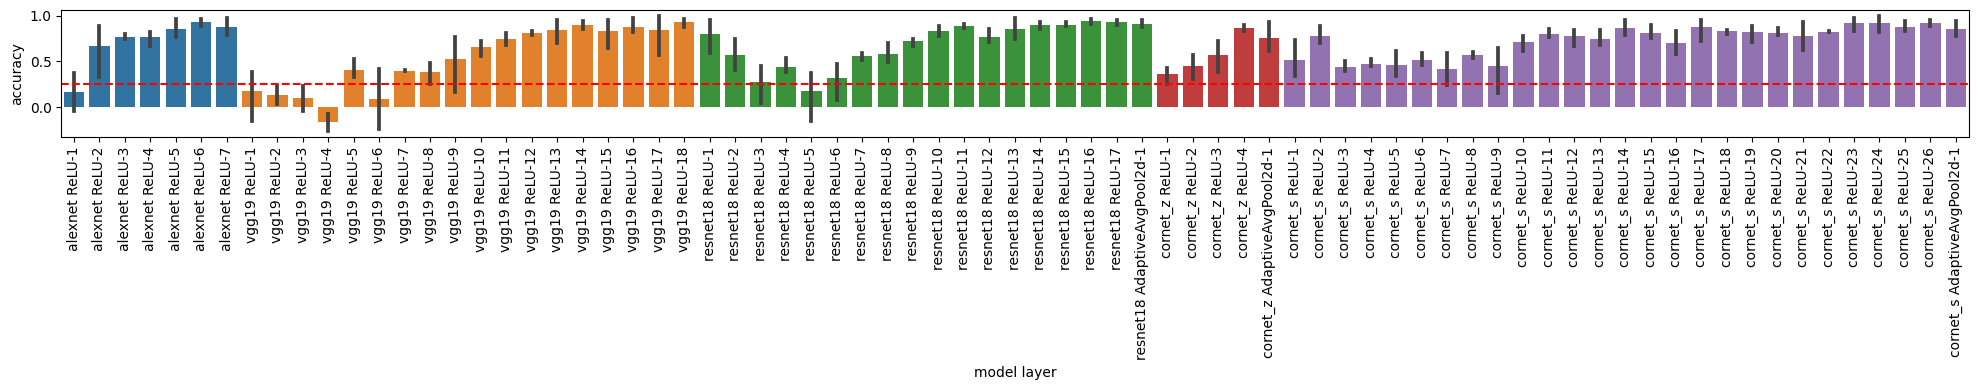

  0%|                                                                                                    | 0/5 [00:00<?, ?it/s]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 13.03it/s]


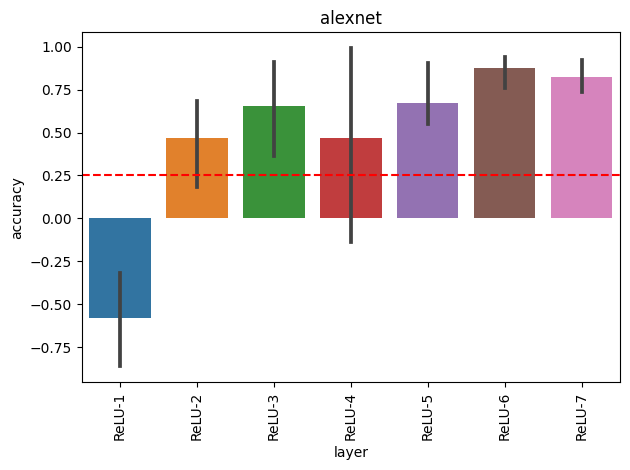

 20%|██████████████████▍                                                                         | 1/5 [00:03<00:15,  3.94s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:17<00:00,  1.04it/s]


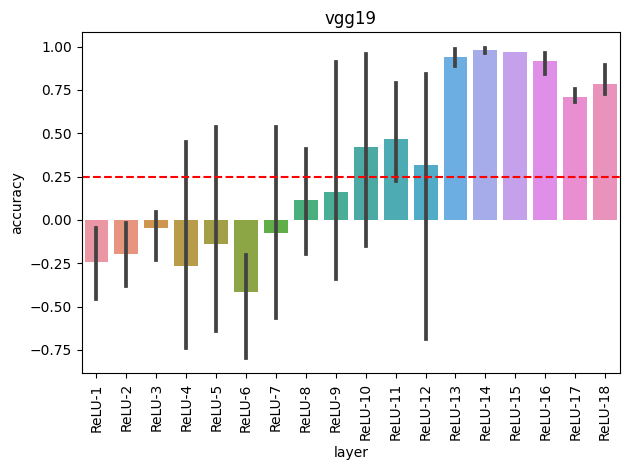

 40%|████████████████████████████████████▊                                                       | 2/5 [00:30<00:51, 17.03s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:02<00:00,  7.18it/s]


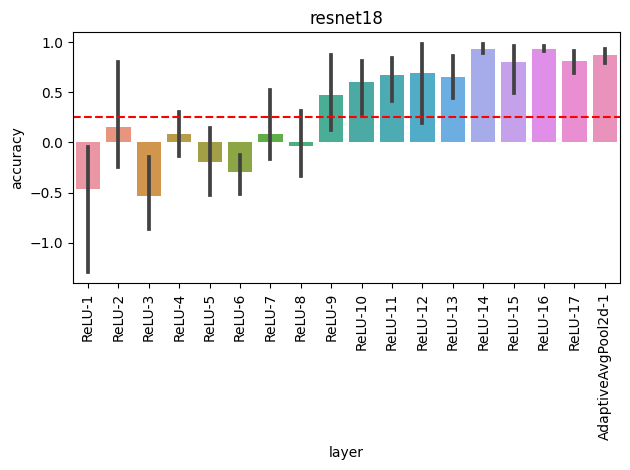

 60%|███████████████████████████████████████████████████████▏                                    | 3/5 [00:37<00:25, 12.70s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.91it/s]


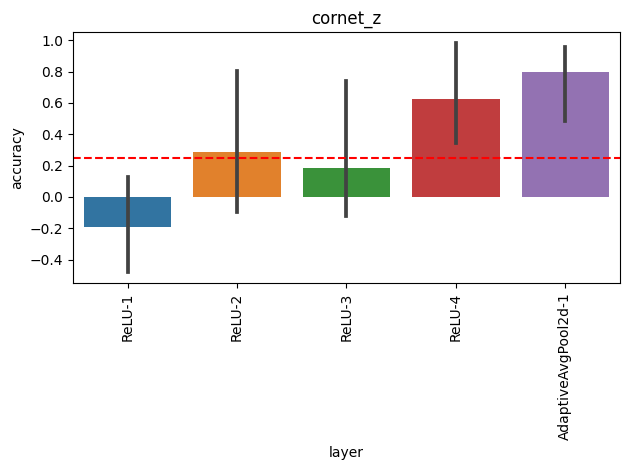

 80%|█████████████████████████████████████████████████████████████████████████▌                  | 4/5 [00:42<00:09,  9.54s/it]

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]


100%|██████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:07<00:00,  3.38it/s]


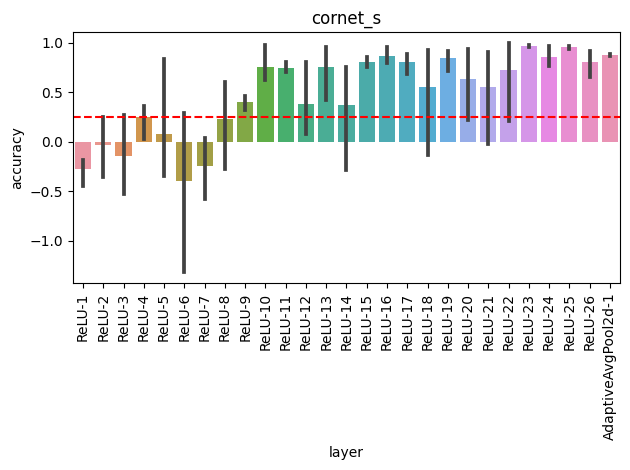

100%|████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:59<00:00, 11.91s/it]


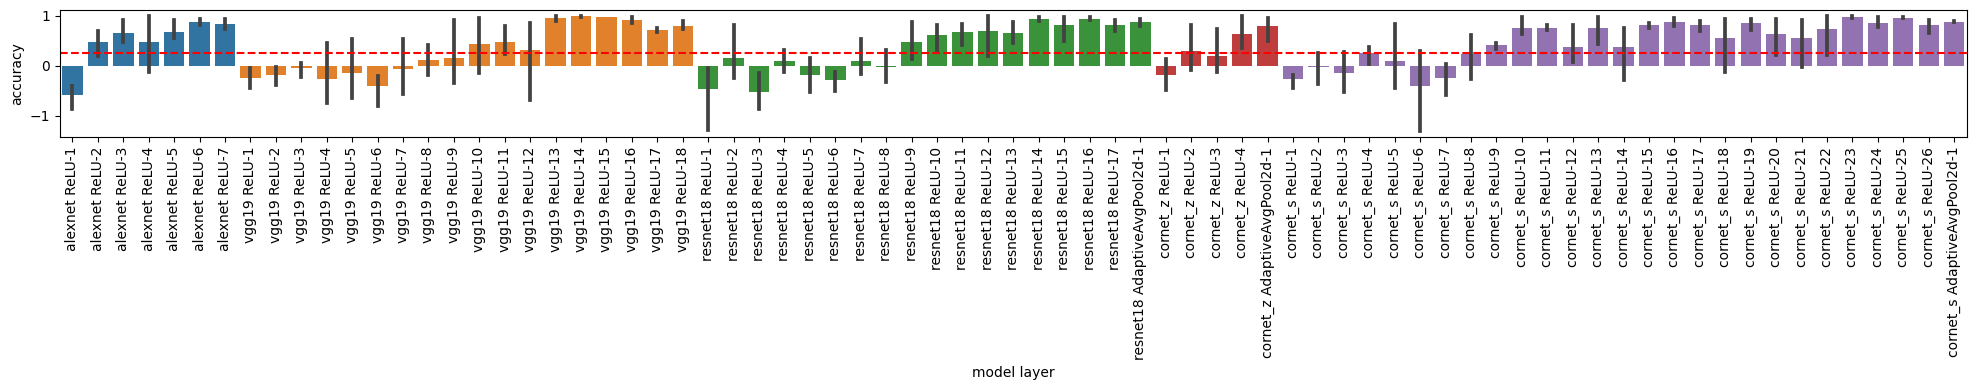

In [16]:
'''
Run for all stim
'''
from tqdm import tqdm


experiment = 'allv1_rect'
for experiment in ['allv1_rect', 'allv1_curv']:
    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}')

    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    cat_num = len(test_dataset.classes)

    model_df = dict(model=[], layer=[], accuracy=[])
    # model_df = pd.DataFrame(columns = models)
    for model_arch in tqdm(models):
        model = load_model(model_arch)
        model_layers = get_empty_feature_maps(model, testloader, names_only = True)
        # in general let's just use the ReLU layers, but also the average pooling over space that occurs in ResNet and CORnet models without rectifcation before the classifier
        layers = [layer for layer in model_layers if 'ReLU' in layer or 'AdaptiveAvgPool2d-1' in layer]
        model.to('cuda')

    #     acts = extract_acts(model, stim_dir, transform, layer_call)
        activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)
        for layer in tqdm(layers):
            acts = activations[layer]

            accs = classify(acts, labels, splits)
            for acc in accs:
                model_df['model'].append(model_arch)
                model_df['layer'].append(layer)
                model_df['accuracy'].append(acc)

        this_df = pd.DataFrame(model_df)
        ax = sns.barplot(data=this_df[this_df['model']==model_arch], x='layer', hue='layer', y='accuracy', dodge=False)
        ax.axhline(y=1/cat_num, color='r', linestyle='--')
        plt.title(model_arch)
        plt.legend().remove()
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        plt.tight_layout()
        plt.savefig(f'figures/{model_arch}_{experiment}_all_layers_acc.png', dpi=200)
        plt.show()

    model_df = pd.DataFrame(model_df)

    model_df['model layer'] = [f'{model} {layer}' for model, layer in zip(model_df['model'], model_df['layer'])]
    fig = plt.figure(figsize=(20,4))
    ax = sns.barplot(model_df, x='model layer', hue='model', y='accuracy',dodge=False )
    ax.axhline(y=1/cat_num, color='r', linestyle='--')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    plt.legend().remove()
    plt.tight_layout()
    plt.savefig(f'figures/models_{experiment}_acc.png', dpi=200)
    plt.show()

# RDMs / correlational analysis

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]

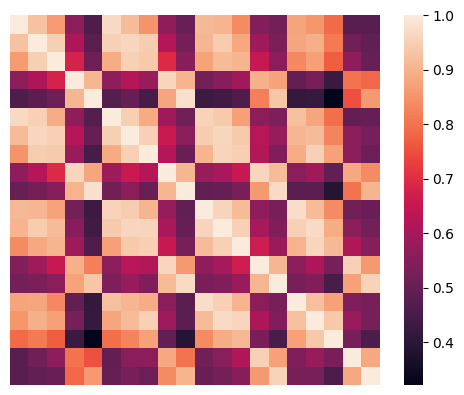

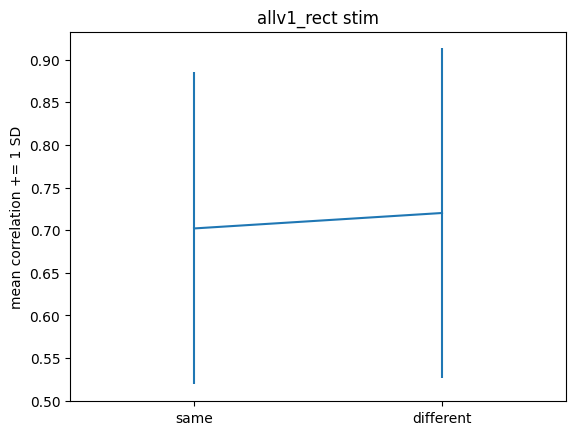

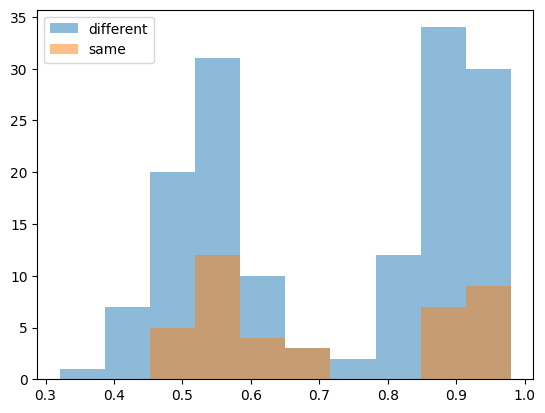

Feature Extraction (Batch):   0%|          | 0/3 [00:00<?, ?it/s]

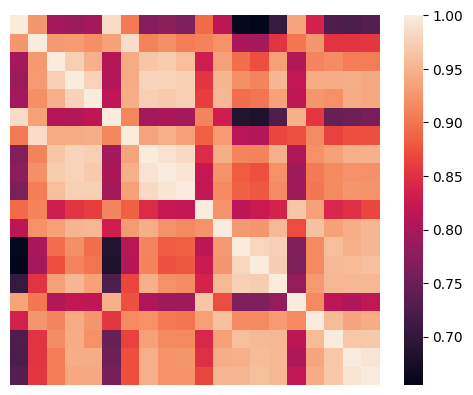

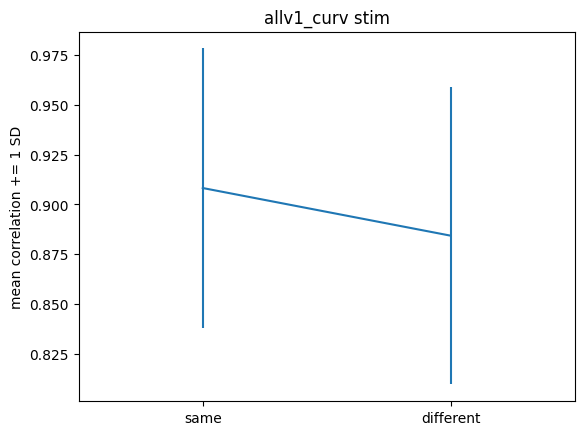

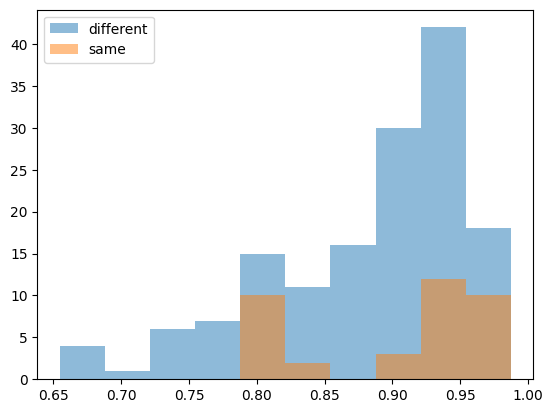

In [17]:
import os
#create correlation matrix for activations
model_arch = 'alexnet'
layer = 'ReLU-7'

for experiment in ['allv1_rect', 'allv1_curv']:

    testloader, test_dataset = get_loader(f'{curr_dir}/stim/{experiment}')
    labels = torch.cat([labels for inputs, labels in testloader]).numpy()
    label_mat = np.zeros((len(labels), len(labels)), dtype=bool)
    for ii, label1 in enumerate(labels):
        for jj, label2 in enumerate(labels):
            label_mat[ii,jj] = label1 == label2
    model = load_model(model_arch)
    model_layers = get_empty_feature_maps(model, testloader, names_only = True)
    layers = [layer for layer in model_layers if 'ReLU' in layer]
    #     layers = layers[-3:]
    model.to('cuda')

    #     acts = extract_acts(model, stim_dir, transform, layer_call)
    activations = get_all_feature_maps(model, testloader, layers_to_retain=layers)

    corr = np.corrcoef(activations[layer])
    
    sns.heatmap(corr)
    #remove axis labels
    plt.xticks([])
    plt.yticks([])
    #remove tick lines
    plt.tick_params(left=False, bottom=False)
    #make square
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig(f'figures/{experiment}_{model_arch}_{layer}_corrcoef_heatmap.png', dpi=200)
    plt.show()
    
    
    trili = np.tril_indices(corr.shape[0], k=-1)
    corr_same = corr[trili][label_mat[trili]]
    corr_diff = corr[trili][np.logical_not(label_mat[trili])]
    plt.errorbar(x=['same', 'different'], y=[corr_same.mean(), corr_diff.mean()], yerr=[corr_same.std(), corr_diff.std()])
    plt.xlim(-0.5,1.5)
    plt.ylabel('mean correlation += 1 SD')
    plt.title(f'{experiment} stim')
    os.makedirs('figures', exist_ok=True)
    plt.savefig(f'figures/{experiment}_{model_arch}_{layer}_corrcoef.png', dpi=200)
    plt.show()
    
    bins = plt.hist(corr_diff, label='different', alpha=0.5, density=False)
    plt.hist(corr_same, bins=bins[1], label='same', alpha=0.5, density=False)
    plt.savefig(f'figures/{experiment}_{model_arch}_{layer}_corrcoef_hist.png', dpi=200)
    plt.legend()
    plt.show()